<a href="https://colab.research.google.com/github/ParissaAmin/Machine-Learning/blob/main/Renewable%20Energy/UCP_Optimization_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

# Code for UCP Implementation

Model Setup

In [14]:
from pyomo.environ import *

# Create the model
model = ConcreteModel()

# Define sets
num_generators = 5
num_hours = 24

model.Generators = RangeSet(num_generators)
model.Time = RangeSet(num_hours)

#Parameter Definitions

In [15]:

min_output = {i: 20 for i in model.Generators}
max_output = {i: 100 for i in model.Generators}
startup_cost = {i: 200 for i in model.Generators}
shutdown_cost = {i: 100 for i in model.Generators}
operating_cost = {i: 10 for i in model.Generators}

In [16]:

demand = {
    t: 100 + 10 * (t % 5) for t in model.Time
}


reserve_factor = 0.1

#Variables

In [17]:
model.P = Var(model.Generators, model.Time, within=NonNegativeReals)
model.u = Var(model.Generators, model.Time, within=Binary)
model.v = Var(model.Generators, model.Time, within=Binary)
model.w = Var(model.Generators, model.Time, within=Binary)

#Objective function

In [18]:
#Minimize total cost
def total_cost(model):
    op_cost = sum(
        model.P[i, t] * operating_cost[i] for i in model.Generators for t in model.Time
    )
    start_cost = sum(
        model.v[i, t] * startup_cost[i] for i in model.Generators for t in model.Time
    )
    shut_cost = sum(
        model.w[i, t] * shutdown_cost[i] for i in model.Generators for t in model.Time
    )
    return op_cost + start_cost + shut_cost


model.Objective = Objective(rule=total_cost, sense=minimize)

#Constraints

Power Balance Constraint

Generator Limits

Reserve Requirement

Startup/Shutdown Constraints

In [19]:
# Demand profile (MW) over 24 hours
demand = {t: 100 + 10 * (t % 5) for t in model.Time}

# 1. Power balance constraint
def demand_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= demand[t]

model.DemandConstraint = Constraint(model.Time, rule=demand_constraint)

In [20]:
# 2. Generator limits using Big-M approach
def generator_min_limit(model, i, t):
    return model.P[i, t] >= model.u[i, t] * min_output[i]

def generator_max_limit(model, i, t):
    return model.P[i, t] <= model.u[i, t] * max_output[i]

model.GeneratorMinLimit = Constraint(model.Generators, model.Time, rule=generator_min_limit)
model.GeneratorMaxLimit = Constraint(model.Generators, model.Time, rule=generator_max_limit)

In [21]:
# Reserve factor (percentage of demand to keep as reserve)
reserve_factor = 0.1

# 3. Reserve requirement
def reserve_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= demand[t] * (1 + reserve_factor)

model.ReserveConstraint = Constraint(model.Time, rule=reserve_constraint)

In [22]:
# 4. Startup/shutdown constraints
def startup_shutdown_rule(model, i, t):
    if t == 1:
        return Constraint.Skip
    return model.u[i, t] - model.u[i, t - 1] == model.v[i, t] - model.w[i, t]


model.StartupShutdown = Constraint(model.Generators, model.Time, rule=startup_shutdown_rule)

In [23]:
!apt-get install -y -qq glpk-utils

In [25]:
!glpsol --version

GLPSOL--GLPK LP/MIP Solver 5.0
Copyright (C) 2000-2020 Free Software Foundation, Inc.

This program has ABSOLUTELY NO WARRANTY.

This program is free software; you may re-distribute it under the terms
of the GNU General Public License version 3 or later.


#Solve the Model

In [26]:
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")
results = solver.solve(model)

#Display Results

In [27]:
# Display total cost
print("Total Cost: $", model.Objective())

# Display generator schedules
for t in model.Time:
    print(f"\nHour {t}:")
    for i in model.Generators:
        print(
            f"  Generator {i}: Power = {model.P[i, t].value:.2f} MW, Status = {int(model.u[i, t].value)}"
        )

Total Cost: $ 31900.0

Hour 1:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 21.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 2:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 32.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 3:
  Generator 1: Power = 100.00 MW, Status = 1
  Generator 2: Power = 43.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 4:
  Generator 1: Power = 54.00 MW, Status = 1
  Generator 2: Power = 100.00 MW, Status = 1
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 0.00 MW, Status = 0

Hour 5:
  Generator 1: Power = 90.00 MW, Status = 1
  Generator 2: Po

## Visualization

In [28]:
!pip uninstall -y pydrive2


In [29]:
!pip install matplotlib pyomo


In [30]:
!pip install --upgrade matplotlib pyomo


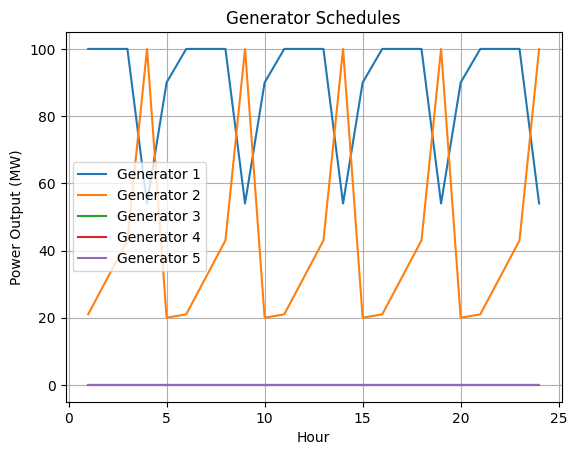

In [31]:
import matplotlib.pyplot as plt

schedules = {i: [model.P[i, t].value for t in model.Time] for i in model.Generators}

for i in model.Generators:
    plt.plot(range(1, num_hours + 1), schedules[i], label=f"Generator {i}")

plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Schedules")
plt.legend()
plt.grid()
plt.show()

#Dataset: National Renewable Energy Laboratory (NREL) - Wind and Solar Resource Data

In [32]:
import requests
import pandas as pd

# Replace with your NREL API Key
api_key = "fvj2ei4nfWzO5LIJ23ePgh998sy2Ce6f3IrU9bfS"

# Define API Endpoint and Parameters
url = "https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv"

# Use a sample location if no specific location is known
params = {
    "wkt": "POINT(-104.9903 39.7392)",  # Denver, CO coordinates (replace as needed)
    "names": "2020",  # Year of data
    "interval": "60",  # Data interval (60 minutes)
    "api_key": api_key,
    "attributes": "ghi,dni,wind_speed",  # Specify attributes: GHI, DNI, wind speed, etc.
    "utc": "true",  # Use UTC time
    "email": "amin.parissa@gmail.com",  # Replace with your registered email
}

# Fetch Data
response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the data to a CSV file
    with open("nrel_data.csv", "w") as file:
        file.write(response.text)
    print("Data downloaded successfully!")

    # Load the CSV into a Pandas DataFrame
    df = pd.read_csv("nrel_data.csv")
    print(df.head())
else:
    print("Error:", response.status_code, response.text)

Data downloaded successfully!
  Source Location ID City State Country Latitude Longitude   Time Zone  \
0  NSRDB      484137    -     -       -    39.73   -104.98           0   
1   Year       Month  Day  Hour  Minute      GHI       DNI  Wind Speed   
2   2020           1    1     0      30        0         0         2.6   
3   2020           1    1     1      30        0         0         3.6   
4   2020           1    1     2      30        0         0         4.4   

   Elevation  Local Time Zone  ... Cloud Type 11 Cloud Type 12 Fill Flag 0  \
0     1604.0             -7.0  ...          Dust         Smoke         NaN   
1        NaN              NaN  ...           NaN           NaN         NaN   
2        NaN              NaN  ...           NaN           NaN         NaN   
3        NaN              NaN  ...           NaN           NaN         NaN   
4        NaN              NaN  ...           NaN           NaN         NaN   

     Fill Flag 1     Fill Flag 2       Fill Flag 3      

#Clean and Process the Data

In [33]:
print(df.columns)  # the column names

Index(['Source', 'Location ID', 'City', 'State', 'Country', 'Latitude',
       'Longitude', 'Time Zone', 'Elevation', 'Local Time Zone',
       'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units',
       'Dew Point Units', 'DHI Units', 'DNI Units', 'GHI Units',
       'Solar Zenith Angle Units', 'Temperature Units', 'Pressure Units',
       'Relative Humidity Units', 'Precipitable Water Units',
       'Wind Direction Units', 'Wind Speed Units', 'Cloud Type -15',
       'Cloud Type 0', 'Cloud Type 1', 'Cloud Type 2', 'Cloud Type 3',
       'Cloud Type 4', 'Cloud Type 5', 'Cloud Type 6', 'Cloud Type 7',
       'Cloud Type 8', 'Cloud Type 9', 'Cloud Type 10', 'Cloud Type 11',
       'Cloud Type 12', 'Fill Flag 0', 'Fill Flag 1', 'Fill Flag 2',
       'Fill Flag 3', 'Fill Flag 4', 'Fill Flag 5', 'Surface Albedo Units',
       'Version'],
      dtype='object')


In [34]:
print(df.columns)
print(f"Number of columns in dataset: {len(df.columns)}")

Index(['Source', 'Location ID', 'City', 'State', 'Country', 'Latitude',
       'Longitude', 'Time Zone', 'Elevation', 'Local Time Zone',
       'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units',
       'Dew Point Units', 'DHI Units', 'DNI Units', 'GHI Units',
       'Solar Zenith Angle Units', 'Temperature Units', 'Pressure Units',
       'Relative Humidity Units', 'Precipitable Water Units',
       'Wind Direction Units', 'Wind Speed Units', 'Cloud Type -15',
       'Cloud Type 0', 'Cloud Type 1', 'Cloud Type 2', 'Cloud Type 3',
       'Cloud Type 4', 'Cloud Type 5', 'Cloud Type 6', 'Cloud Type 7',
       'Cloud Type 8', 'Cloud Type 9', 'Cloud Type 10', 'Cloud Type 11',
       'Cloud Type 12', 'Fill Flag 0', 'Fill Flag 1', 'Fill Flag 2',
       'Fill Flag 3', 'Fill Flag 4', 'Fill Flag 5', 'Surface Albedo Units',
       'Version'],
      dtype='object')
Number of columns in dataset: 46


In [35]:
import pandas as pd

# Load the dataset
df = pd.read_csv("nrel_data.csv", skiprows=2)  # Skip metadata rows if necessary

# Confirm column names and count
print("Columns in the dataset:", df.columns)
print(f"Number of columns: {len(df.columns)}")

# Rename columns for clarity (if needed)
df.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed']

# Select relevant columns
relevant_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed']
df = df[relevant_columns]

# Convert to numeric and handle missing values
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Preview the cleaned dataset
print("Cleaned Dataset Preview:")
print(df.head())

# Save the cleaned data for further analysis
df.to_csv("cleaned_nrel_data.csv", index=False)
print("Cleaned dataset saved to 'cleaned_nrel_data.csv'")

Columns in the dataset: Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'Wind Speed'], dtype='object')
Number of columns: 8
Cleaned Dataset Preview:
   Year  Month  Day  Hour  Minute  GHI  DNI  Wind Speed
0  2020      1    1     0      30    0    0         2.6
1  2020      1    1     1      30    0    0         3.6
2  2020      1    1     2      30    0    0         4.4
3  2020      1    1     3      30    0    0         5.2
4  2020      1    1     4      30    0    0         5.6
Cleaned dataset saved to 'cleaned_nrel_data.csv'


#Integrating Data into UCP Model

In [36]:
# Aggregate data to hourly intervals
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_hourly = df.resample('H', on='Datetime').mean()

# Drop unnecessary columns
df_hourly = df_hourly[['GHI', 'DNI', 'Wind Speed']]
print(df_hourly.head())

# Save data
df_hourly.to_csv("aggregated_nrel_data.csv")
print("Aggregated data saved to 'aggregated_nrel_data.csv'")

                     GHI  DNI  Wind Speed
Datetime                                 
2020-01-01 00:00:00  0.0  0.0         2.6
2020-01-01 01:00:00  0.0  0.0         3.6
2020-01-01 02:00:00  0.0  0.0         4.4
2020-01-01 03:00:00  0.0  0.0         5.2
2020-01-01 04:00:00  0.0  0.0         5.6
Aggregated data saved to 'aggregated_nrel_data.csv'


<ipython-input-36-26b3f43c031c>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='Datetime').mean()


#Machine Learning Integration

In [37]:
!pip uninstall -y pydrive2


In [38]:
!pip install --upgrade scikit-learn pandas numpy pyomo


In [39]:
!pip uninstall -y pydrive2 pyomo


Found existing installation: Pyomo 6.8.2
Uninstalling Pyomo-6.8.2:
  Successfully uninstalled Pyomo-6.8.2


In [40]:
!pip install pyomo


  Using cached Pyomo-6.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
Using cached Pyomo-6.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)


In [1]:
!pip install --upgrade scikit-learn pandas numpy


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyomo.environ import *


df_hourly = pd.read_csv("aggregated_nrel_data.csv", parse_dates=["Datetime"], index_col="Datetime")


base_demand = 100 + 20 * np.sin(2 * np.pi * df_hourly.index.hour / 24)


solar_efficiency = 0.2
wind_efficiency = 0.3

# Calculate renewable generation and net demand
df_hourly['Renewable_Generation'] = df_hourly['GHI'] * solar_efficiency + df_hourly['Wind Speed'] * wind_efficiency
df_hourly['Base_Demand'] = base_demand
df_hourly['Net_Demand'] = df_hourly['Base_Demand'] - df_hourly['Renewable_Generation']

In [3]:
# Features and target
features = df_hourly[['GHI', 'Wind Speed']].copy()
features['Hour'] = df_hourly.index.hour
features['DayOfWeek'] = df_hourly.index.dayofweek
features['Month'] = df_hourly.index.month

target = df_hourly['Net_Demand']

In [5]:
# Check for missing values in the target variable
print("Number of missing values in target:", target.isna().sum())

# Drop rows with missing Net_Demand
data_cleaned = df_hourly.dropna(subset=['Net_Demand'])
print("Data cleaned. Rows remaining:", len(data_cleaned))

# Update features and target
features = data_cleaned[['GHI', 'Wind Speed']].copy()
features['Hour'] = data_cleaned.index.hour
features['DayOfWeek'] = data_cleaned.index.dayofweek
features['Month'] = data_cleaned.index.month

target = data_cleaned['Net_Demand']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
predictions = rf_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")



Number of missing values in target: 24
Data cleaned. Rows remaining: 8760
Mean Squared Error: 0.26993398486302206


In [7]:
# Step 3: Forecast Demand for the Next 24 Hours

latest_features = features.iloc[-24:]
predicted_demand = rf_model.predict(latest_features)


#Integrating ML Predictions into the UCP Model

In [9]:

# Define the UCP model
num_generators = 5
num_hours = 24

model = ConcreteModel()
model.Generators = RangeSet(num_generators)
model.Time = RangeSet(num_hours)

In [10]:
# Generator parameters
min_output = {i: 20 for i in model.Generators}
max_output = {i: 100 for i in model.Generators}
startup_cost = {i: 200 for i in model.Generators}
shutdown_cost = {i: 100 for i in model.Generators}
operating_cost = {i: 10 for i in model.Generators}

# Variables
model.P = Var(model.Generators, model.Time, within=NonNegativeReals)
model.u = Var(model.Generators, model.Time, within=Binary)
model.v = Var(model.Generators, model.Time, within=Binary)
model.w = Var(model.Generators, model.Time, within=Binary)

In [11]:
# Objective function
def total_cost(model):
    op_cost = sum(
        model.P[i, t] * operating_cost[i] for i in model.Generators for t in model.Time
    )
    start_cost = sum(
        model.v[i, t] * startup_cost[i] for i in model.Generators for t in model.Time
    )
    shut_cost = sum(
        model.w[i, t] * shutdown_cost[i] for i in model.Generators for t in model.Time
    )
    return op_cost + start_cost + shut_cost

model.Objective = Objective(rule=total_cost, sense=minimize)

#Constraints

In [12]:

predicted_demand_dict = {t: predicted_demand[t - 1] for t in model.Time}

def demand_constraint(model, t):
    return sum(model.P[i, t] for i in model.Generators) >= predicted_demand_dict[t]

model.DemandConstraint = Constraint(model.Time, rule=demand_constraint)

In [13]:
# Generator limits
def generator_min_limit(model, i, t):
    return model.P[i, t] >= model.u[i, t] * min_output[i]

def generator_max_limit(model, i, t):
    return model.P[i, t] <= model.u[i, t] * max_output[i]

model.GeneratorMinLimit = Constraint(model.Generators, model.Time, rule=generator_min_limit)
model.GeneratorMaxLimit = Constraint(model.Generators, model.Time, rule=generator_max_limit)

In [14]:

def startup_shutdown_rule(model, i, t):
    if t == 1:
        return Constraint.Skip
    return model.u[i, t] - model.u[i, t - 1] == model.v[i, t] - model.w[i, t]

model.StartupShutdown = Constraint(model.Generators, model.Time, rule=startup_shutdown_rule)

In [16]:
!apt-get install -y glpk-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [17]:

!which glpsol

/usr/bin/glpsol


In [18]:
solver = SolverFactory("glpk", executable="/usr/bin/glpsol")  # Adjust the path if necessary
results = solver.solve(model)

# Display results
print("Total Cost:", model.Objective())
for t in model.Time:
    print(f"Hour {t}:")
    for i in model.Generators:
        print(
            f"  Generator {i}: Power = {model.P[i, t].value:.2f} MW, Status = {int(model.u[i, t].value)}"
        )

Total Cost: 19164.245668116844
Hour 1:
  Generator 1: Power = 79.58 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 20.00 MW, Status = 1
Hour 2:
  Generator 1: Power = 84.55 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 20.00 MW, Status = 1
Hour 3:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 89.21 MW, Status = 1
Hour 4:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Power = 0.00 MW, Status = 0
  Generator 3: Power = 0.00 MW, Status = 0
  Generator 4: Power = 0.00 MW, Status = 0
  Generator 5: Power = 93.24 MW, Status = 1
Hour 5:
  Generator 1: Power = 20.00 MW, Status = 1
  Generator 2: Po

#Visualizing the Results

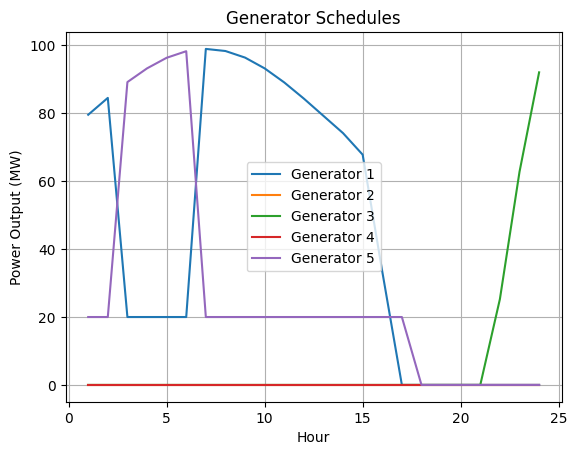

In [19]:
import matplotlib.pyplot as plt

# Extract data for plotting
hours = list(model.Time)
power_outputs = {i: [model.P[i, t].value for t in model.Time] for i in model.Generators}

# Plot
for gen, output in power_outputs.items():
    plt.plot(hours, output, label=f"Generator {gen}")

plt.xlabel("Hour")
plt.ylabel("Power Output (MW)")
plt.title("Generator Schedules")
plt.legend()
plt.grid()
plt.show()

#Plot Generator Status

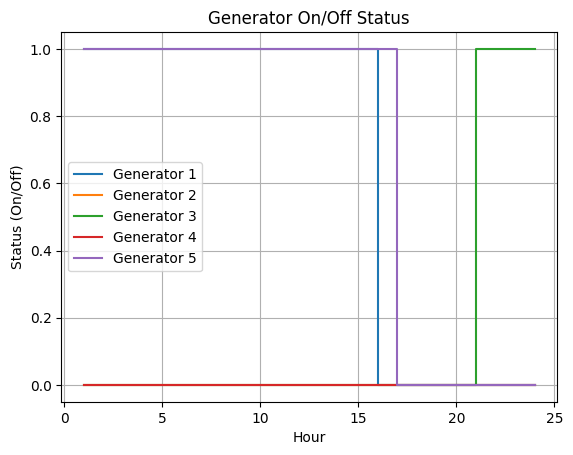

In [20]:
statuses = {i: [model.u[i, t].value for t in model.Time] for i in model.Generators}

for gen, status in statuses.items():
    plt.step(hours, status, label=f"Generator {gen}")

plt.xlabel("Hour")
plt.ylabel("Status (On/Off)")
plt.title("Generator On/Off Status")
plt.legend()
plt.grid()
plt.show()